In [1]:
import sys
import os
import numpy as np
import pandas as pd
import scipy
import math
from scipy.special import loggamma, polygamma
from copy import deepcopy
from random import random, randint, sample, shuffle
from tqdm import tqdm
import warnings

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(style='ticks', font_scale=1.4)

functions_dir_path = './functions/'
sys.path.append(functions_dir_path)

from beta_estim_funct import *
from nsb_funct import *


In [2]:
def df_cleaninf(df):    
    # Replace infinite updated data with nan
    df.replace([np.inf, -np.inf], np.nan, inplace=True) 
    # Drop rows with NaN
    df.dropna(inplace=True)
    return df

In [3]:
# results directory
project_dir = os.getcwd()
result_dir = project_dir + '/results/'
fig_dir = project_dir + '/figures/'

### define data frame

In [4]:
def mkdf():
    df = pd.DataFrame({
        'K' : df_K,
        'N' : df_N,
        'beta' : df_beta,
        'bstar' : df_bstar,
        'bstarNSB' : df_bstarNSB,
        'KLtrue' : df_KLtrue,
        'KLbay' : df_KLbay,
        'KLbay1' : df_KLbay1,
        'KLhs' : df_KLhs,
        
        })
    
    df['delta_bay_kl'] = (df.KLbay - df.KLtrue)
    df['delta_bay1_kl'] = (df.KLbay1 - df.KLtrue)
    df['delta_hs_kl'] = (df.KLhs - df.KLtrue)
    return df

# Run many times MAP

In [5]:
BETAs = [0.01,1,10]
Ns = [20,30,40,50,60,80,100,500,1000,5000,10000] #[20,30,40,50,80,100,1000,5000,10000]
Ks = [1000]

NREP_MAP = 1000

In [ ]:
save_df = True
show_res = False
savefigure=False
legend = False

for K in Ks:
    for bb in range(len(BETAs)):
        BETA = BETAs[bb]
        filename = 'KL_K%d_B%g_new'  % (K, BETA)
        try:
            df = pd.read_csv(result_dir+filename+'.csv')
            ready = True
        except:
            ready = False        
        # If not done, do it
        if not ready:
            print('>>> K=%d  BETA=%g  ' % (K, BETA), file=sys.stderr)
            df_beta,df_beta, df_bstar,df_bstarNSB, df_N,df_K= [], [], [], [], [], []
            df_KLtrue, df_KLbay,df_KLbay1, df_KLhs = [], [], [], []
            for N in tqdm(Ns):
                for rep in range(NREP_MAP):
                    # Generate the data, initial values of sigma, estimate beta*
                    multi, true_rhos, _, bstar, _,bstarNSB, _ = \
                            generate_data(K,N, BETA, niter = 20, add_zeroes=False)

                    # PARAMETERS   
                    df_beta.append(BETA)
                    df_bstar.append(bstar)
                    df_bstarNSB.append(bstarNSB)
                    df_N.append(N)
                    df_K.append(K)

                    # KLD 
                    KLtrue, KLbay,KLbay1, KLhs = 0, bay_kl_same(true_rhos,multi, bstar), bay_kl_same(true_rhos,multi, 1), hs_kl_same(true_rhos,multi)                    
                    df_KLtrue.append(KLtrue),df_KLbay.append(KLbay),df_KLbay1.append(KLbay1),df_KLhs.append(KLhs)

                    # Screen output
                    if show_res == True:
                        print('rep=%d/%d K=%d N=%d BETA=%g BETA*=%g' 
                                  % (rep+1,NREP_MAP,K, N, BETA, round(bstar,3))
                                 )
                        print(
                            '    JS=%g JSbay=%g JSml=%g JShs=%g | KL=%g KLbay=%g KLhs=%g'
                              % (round(JStrue,3), round(JSbay,4), round(JSml,4), round(JShs,4),round(KLtrue,3), round(KLbay,4), round(KLhs,4))
                             )
            # Prepare data frame        
            df = mkdf()
            
            # Save data frame
            df.to_csv(result_dir+filename+'.csv', index=False)



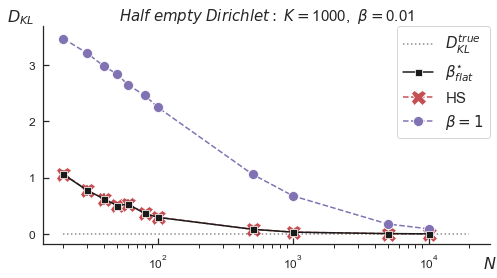

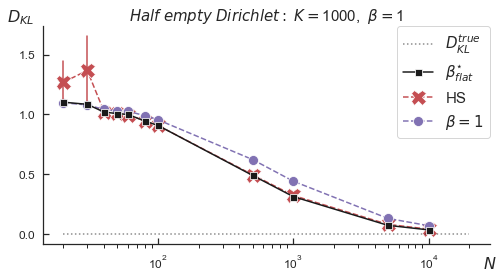

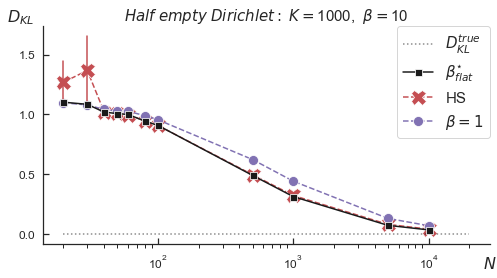

In [6]:
## add colums for MSE and inset
for K in Ks:
    for bb in range(len(BETAs)):
        BETA = BETAs[bb]
        filename = 'KL_zeroes_K%d_B%g'  % (K, BETA)
        try:
            df = pd.read_csv(result_dir+filename+'.csv')
            ready = True
        except:
            ready = False
        # clean df from inf

        
        ############################## plots ################################ 
        # clean df from inf
        df_clean = df_cleaninf(df)
        #         df_clean = df_clean[df_clean["N"] > 20]
        
        # mean squared error
        #         mean_bay=df_clean.groupby('N').mean()['KLbay']
        #         mean_hs=df_clean.groupby('N').mean()['KLhs']
        #         mean_bay1=df_clean.groupby('N').mean()['KLbay1']
        
        std_bay=df_clean.groupby('N').std()['KLbay']
        std_hs=df_clean.groupby('N').std()['KLhs']
        std_bay1=df_clean.groupby('N').std()['KLbay1']
        
        #         df_clean['mse_bay'] = (df_clean.KLbay)**2
        #         df_clean['mse_hs'] = (df_clean.KLhs)**2
        #         df_clean['mse_bay1'] = (df_clean.KLbay1)**2
               
        fig, ax = plt.subplots(figsize=[8,4])
        palette = sns.color_palette()

        ax.plot((min(Ns), max(Ns)+10000), (0, 0), 'k:',alpha=0.5, label=r'$D_{KL}^{true}$')

        sns.lineplot(x='N', y='delta_bay_kl', data=df_clean, err_style="bars",
                     marker='s', label=r'$\beta^{\star}_{flat}$',zorder=5,color='k',markersize=7,errorbar='se')
        sns.lineplot(x='N', y='delta_hs_kl', data=df_clean, err_style="bars",
                     linestyle = '--', marker='X', label='HS',zorder=0,color=palette[3],markersize=15,errorbar='se')
        sns.lineplot(x='N', y='delta_bay1_kl', data=df_clean, err_style="bars",
                    linestyle = '--', marker='o', label= r'$\beta=1$',zorder=0,color=palette[4],markersize=10,errorbar='se')


        ## title 
        ax.set_title(r'$Half$ $empty$ $Dirichlet:$ $K=$%d,  $\beta=$%s' % (K, str(BETA)), fontsize=15, x=0.5, y=1)
        #         ax.set_title(r'$K=$%d,  $\beta=$%s' % (K, str(BETA)), fontsize=15, x=0.5, y=1)

        ## axis labels and ticks
        ax.set_ylabel(r'$D_{KL}$', rotation = 0,fontsize=16)

        ax.set_xlabel(r'$N$', rotation = 0,fontsize=16)
        ax.yaxis.set_label_coords(-.05, 1)
        ax.xaxis.set_label_coords(1, -.05)
        ax.locator_params(axis='y', nbins=5) # number of ticks

        sns.despine() # hide up and right borders
        # ax.grid(axis='y')
        plt.xscale('log')
        #         plt.yscale('log')
        #         plt.xlim(30,10000)

        ax.tick_params(axis="y",direction="in", pad=+8, labelsize=12)
        ax.tick_params(axis="x",direction="in", pad=+8, labelsize=12)
        
        ax.legend(loc='best', borderaxespad=0,prop={'size': 15},frameon=True) # title = 'S='+str(round(S,3)),title_fontsize=12
                
        plt.show()


